In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import os
import numpy as np
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


class DataScientist:
    def __init__(self, sett):
        self.sett = sett
        self.xy_train = joblib.load('/content/drive/MyDrive/xy_train.joblib')
        self.models = {}

    def fit(self):
        used_indices = set()
        previous_model = None

        # Ensure keys are processed in order
        for key in sorted(self.xy_train.keys()):
            df = self.xy_train[key]

            # Separate features and target
            x = df.drop(columns=['y'])
            y = df['y']

            # Get new indices not used in previous training
            new_indices = df.index.difference(used_indices)
            used_indices.update(df.index)

            x_new = x.loc[new_indices]
            y_new = y.loc[new_indices]

            # Compute class weights to balance the classes
            unique_classes = np.unique(y_new)
            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=unique_classes,
                y=y_new
            )
            class_weight_dict = dict(zip(unique_classes, class_weights))

            # EarlyStopping callback
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )

            # Neural Network Model
            if previous_model is None:
                # Define a new model
                model_nn = Sequential()
                model_nn.add(Dense(128, activation='relu', input_shape=(x_new.shape[1],)))
                model_nn.add(Dense(128, activation='relu'))
                model_nn.add(Dense(1, activation='sigmoid'))
                model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
            else:
                model_nn = previous_model

            # Train the neural network model with early stopping and class weights
            model_nn.fit(
                x_new,
                y_new,
                epochs=10,
                batch_size=10000,
                validation_split=0.2,
                callbacks=[early_stopping],
                class_weight=class_weight_dict,
                verbose=1
            )

            # Logistic Regression Model without class weights
            model_lr = LogisticRegression(max_iter=10000)
            model_lr.fit(x, y)

            # Logistic Regression Model with balanced class weights
            model_lr_balanced = LogisticRegression(class_weight='balanced', max_iter=10000)
            model_lr_balanced.fit(x, y)

            # Save the models with the corresponding key
            self.models[key] = {
                'neural_network': model_nn,
                'logistic_regression': model_lr,
                'logistic_regression_balanced': model_lr_balanced
            }
            previous_model = model_nn

        # Save all models to the specified directory
        if not os.path.exists('/content/drive/MyDrive/'):
            os.makedirs('/content/drive/MyDrive/')

        for key, model_dict in self.models.items():
            # Save neural network model
            model_dict['neural_network'].save(f'/content/drive/MyDrive/model_nn_{key}.keras')

            # Save logistic regression model without class weights
            joblib.dump(model_dict['logistic_regression'], f'/content/drive/MyDrive/model_lr_{key}.joblib')

            # Save logistic regression model with balanced class weights
            joblib.dump(model_dict['logistic_regression_balanced'], f'/content/drive/MyDrive/model_lr_balanced_{key}.joblib')

In [ ]:
import joblib

# Defina as configurações necessárias
sett = {}  # Ajuste conforme necessário

# Crie uma instância da classe DataScientist
data_scientist = DataScientist(sett)

# Chame o método fit para treinar os modelos
data_scientist.fit()


In [ ]:
import os
import joblib
import pandas as pd
from tensorflow.keras.models import load_model


class MLOps:
    def __init__(self, sett):
        self.sett = sett
        self.xy_test = joblib.load('/content/drive/MyDrive/xy_test.joblib')
        self.models = {}

        # Load all models from the specified directory
        model_dir = '/content/drive/MyDrive/'
        for filename in os.listdir(model_dir):
            # Extract the key (date) and model type from the filename
            if filename.endswith('.keras'):
                # Neural Network Model
                if filename.startswith('model_nn_'):
                    key = filename.replace('model_nn_', '').replace('.keras', '')
                    if key not in self.models:
                        self.models[key] = {}
                    self.models[key]['neural_network'] = load_model(os.path.join(model_dir, filename))
            elif filename.endswith('.joblib'):
                # Logistic Regression Models
                if filename.startswith('model_lr_balanced_'):
                    key = filename.replace('model_lr_balanced_', '').replace('.joblib', '')
                    if key not in self.models:
                        self.models[key] = {}
                    self.models[key]['logistic_regression_balanced'] = joblib.load(os.path.join(model_dir, filename))
                elif filename.startswith('model_lr_'):
                    key = filename.replace('model_lr_', '').replace('.joblib', '')
                    if key not in self.models:
                        self.models[key] = {}
                    self.models[key]['logistic_regression'] = joblib.load(os.path.join(model_dir, filename))

    def predict(self):
        predictions = {}

        # Ensure the predictions directory exists
        predictions_dir = '/content/drive/MyDrive/'
        if not os.path.exists(predictions_dir):
            os.makedirs(predictions_dir)

        for date_key, data in self.xy_test.items():
            # Check if there's a model for this date
            if date_key in self.models:
                model_dict = self.models[date_key]

                # Separate features and target
                x_test = data.drop(columns=['y'])
                y_true = data['y']

                # Initialize a DataFrame to store predictions
                predictions_df = pd.DataFrame({'y_true': y_true})

                for model_name, model in model_dict.items():
                    if model_name == 'neural_network':
                        # Neural Network Prediction
                        y_pred = model.predict(x_test)
                        y_pred = y_pred.flatten()
                    else:
                        # Logistic Regression Prediction
                        y_pred = model.predict_proba(x_test)[:, 1]

                    # Add predictions to the DataFrame
                    predictions_df[f'y_pred_{model_name}'] = y_pred

                # Store predictions for the current date key
                predictions[date_key] = predictions_df
            else:
                print(f"No model found for date {date_key}. Skipping prediction for this date.")

        # Save the predictions dictionary using joblib
        joblib.dump(predictions, os.path.join(predictions_dir, 'predictions.joblib'))

In [ ]:
import joblib
import os
from tensorflow.keras.models import load_model
import pandas as pd

# Defina as configurações necessárias
sett = {}  # Ajuste conforme necessário

# Criar uma instância da classe MLOps
ml_ops = MLOps(sett)

# Chame o método predict para fazer previsões
ml_ops.predict()

# As previsões serão salvas em '/content/drive/MyDrive/predictions.joblib'

Data Key: 2011_2014
    DATE_REF  TRADINGITEM_ID  y_true  y_pred_neural_network  \
0 2015-01-01          324161       0               0.094627   
1 2015-01-01          324285       0               0.016879   
2 2015-01-01          324451       0               0.151270   
3 2015-01-01          324477       0               0.077405   
4 2015-01-01          324489       0               0.074450   

   y_pred_logistic_regression  y_pred_logistic_regression_balanced  LogReturns  
0                    0.000473                             0.151696    0.004669  
1                    0.000159                             0.016892    0.004669  
2                    0.000265                             0.019369    0.004669  
3                    0.000948                             0.110645    0.004669  
4                    0.000549                             0.078780    0.004669  


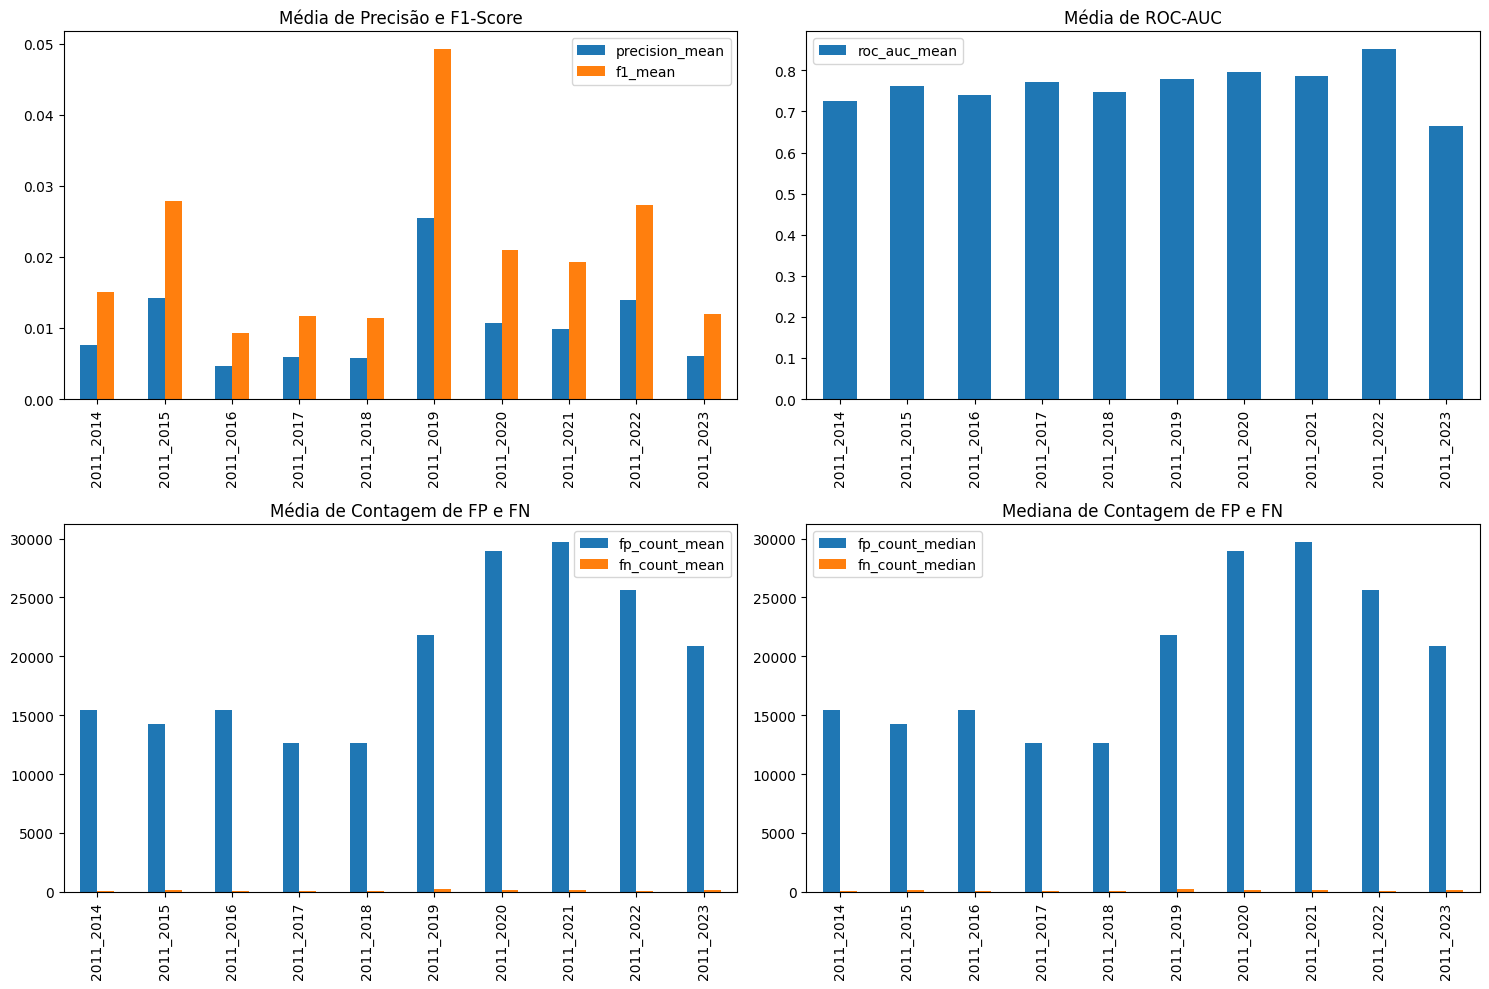

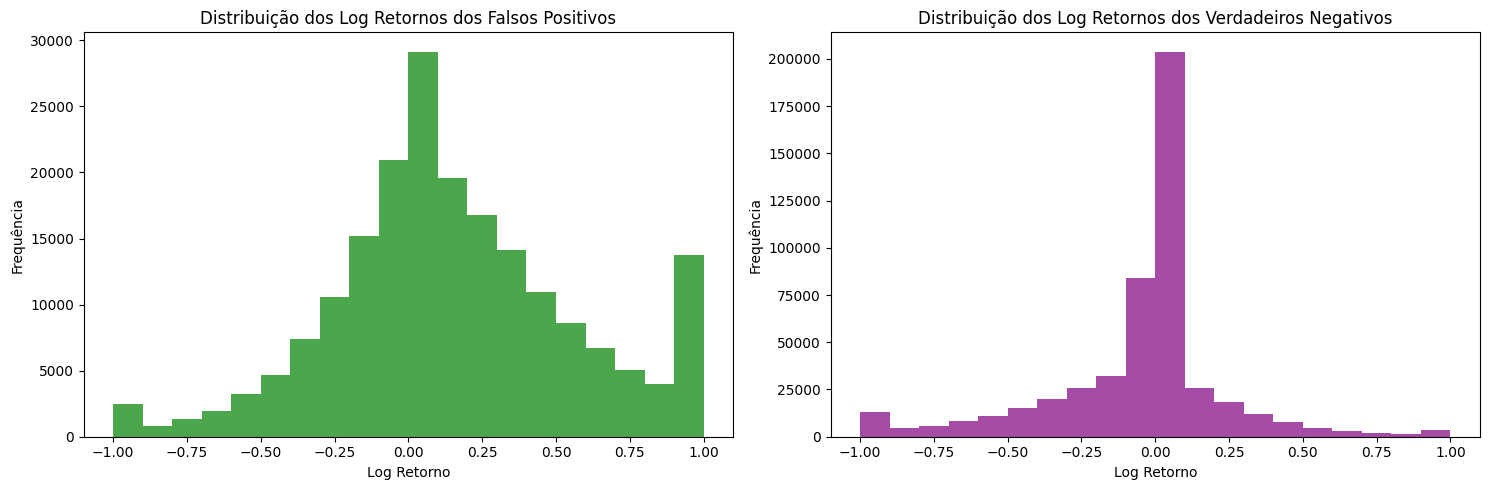

            fp_mean fp_median   fn_mean fn_median fp_count_mean fn_count_mean  \
2011_2014  0.309335  0.309335  0.368984  0.368984       15438.0          69.0   
2011_2015  0.292355  0.292355  0.357367  0.357367       14226.0         114.0   
2011_2016  0.295854  0.295854   0.37931   0.37931       15401.0          44.0   
2011_2017  0.223006  0.223006   0.43609   0.43609       12646.0          58.0   
2011_2018  0.208455  0.208455   0.47482   0.47482       12648.0          66.0   
2011_2019  0.303539  0.303539   0.28839   0.28839       21768.0         231.0   
2011_2020  0.314718  0.314718  0.261283  0.261283       28899.0         110.0   
2011_2021  0.288774  0.288774  0.298329  0.298329       29740.0         125.0   
2011_2022  0.274705  0.274705  0.173913  0.173913       25611.0          76.0   
2011_2023  0.291669  0.291669  0.520755  0.520755       20901.0         138.0   

          fp_count_median fn_count_median  tpr_mean  tnr_mean  ...   f1_mean  \
2011_2014         15438.0   

In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Carregar as duas bases
predictions = joblib.load('/content/drive/MyDrive/predictions.joblib')
xy_test = joblib.load('/content/drive/MyDrive/xy_test.joblib')

# Fazer o join para cada date_key em predictions
for date_key, df_predictions in predictions.items():
    if date_key in xy_test:
        df_xy_test = xy_test[date_key]
        # Redefinir o índice para transformar 'LogReturns' em uma coluna
        df_xy_test = df_xy_test.reset_index()

        # Garantir que 'DATE_REF', 'TRADINGITEM_ID' e 'LogReturns' estão nas colunas de xy_test[date_key]
        if all(col in df_xy_test.columns for col in ['DATE_REF', 'TRADINGITEM_ID', 'LogReturns']):
            # Fazer o left join com base em 'DATE_REF' e 'TRADINGITEM_ID'
            df_merged = pd.merge(df_predictions, df_xy_test[['DATE_REF', 'TRADINGITEM_ID', 'LogReturns']],
                                 on=['DATE_REF', 'TRADINGITEM_ID'], how='left')

            # Atualizar o DataFrame no dicionário predictions
            predictions[date_key] = df_merged
        else:
            print(f"As colunas 'DATE_REF', 'TRADINGITEM_ID' e 'LogReturns' não foram encontradas em xy_test para a data_key: {date_key}")
    else:
        print(f"A chave {date_key} não foi encontrada em xy_test")

# Verificar as primeiras linhas de um DataFrame de exemplo após o merge
for date_key, df in predictions.items():
    print(f"Data Key: {date_key}")
    print(df.head())
    break

# Função para calcular várias métricas
def calculate_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tpr = recall_score(y_true, y_pred)
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_accuracy = (tpr + tnr) / 2
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    metrics = {
        "True Positive Rate (Recall)": tpr,
        "True Negative Rate (Specificity)": tnr,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr,
        "Precision": precision,
        "F1-Score": f1,
        "Matthews Correlation Coefficient": mcc,
        "Balanced Accuracy": balanced_accuracy,
        "ROC-AUC": roc_auc,
        "False Positive Count": fp,
        "False Negative Count": fn
    }

    return metrics

# Função para analisar as métricas por data_key para 'y_pred_neural_network'
def analyze_metrics_by_date(predictions):
    results = {}

    for date_key, df in predictions.items():
        metrics_list = []

        y_true = df['y_true']
        if 'y_pred_neural_network' in df.columns:
            y_pred_prob = df['y_pred_neural_network'].values

            metrics = calculate_metrics(y_true, y_pred_prob)
            metrics_list.append(metrics)

        metrics_df = pd.DataFrame(metrics_list)

        results[date_key] = {
            "fp_mean": metrics_df["False Positive Rate"].mean(),
            "fp_median": metrics_df["False Positive Rate"].median(),
            "fp_quartiles": metrics_df["False Positive Rate"].quantile([0.25, 0.5, 0.75]).tolist(),
            "fn_mean": metrics_df["False Negative Rate"].mean(),
            "fn_median": metrics_df["False Negative Rate"].median(),
            "fn_quartiles": metrics_df["False Negative Rate"].quantile([0.25, 0.5, 0.75]).tolist(),
            "fp_count_mean": metrics_df["False Positive Count"].mean(),
            "fn_count_mean": metrics_df["False Negative Count"].mean(),
            "fp_count_median": metrics_df["False Positive Count"].median(),
            "fn_count_median": metrics_df["False Negative Count"].median(),
            "tpr_mean": metrics_df["True Positive Rate (Recall)"].mean(),
            "tnr_mean": metrics_df["True Negative Rate (Specificity)"].mean(),
            "precision_mean": metrics_df["Precision"].mean(),
            "f1_mean": metrics_df["F1-Score"].mean(),
            "mcc_mean": metrics_df["Matthews Correlation Coefficient"].mean(),
            "balanced_accuracy_mean": metrics_df["Balanced Accuracy"].mean(),
            "roc_auc_mean": metrics_df["ROC-AUC"].mean(),
        }

    return results

# Função para plotar a distribuição de log retornos dos FP e TN para 'y_pred_neural_network'
def plot_distributions(predictions):
    log_returns_fp = []
    log_returns_tn = []

    for date_key, df in predictions.items():
        y_true = df['y_true']
        if 'y_pred_neural_network' in df.columns:
            y_pred_prob = df['y_pred_neural_network'].values
            y_pred = (y_pred_prob >= 0.5).astype(int)

            fp_indices = (y_true == 0) & (y_pred == 1)
            tn_indices = (y_true == 0) & (y_pred == 0)

            # Calcular log retornos dos falsos positivos e verdadeiros negativos
            try:
                log_returns_fp.extend(df['LogReturns'][fp_indices])
                log_returns_tn.extend(df['LogReturns'][tn_indices])
            except KeyError as e:
                print(f"KeyError: {e}")

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(log_returns_fp, bins=20, color='green', alpha=0.7)
    ax[0].set_title('Distribuição dos Log Retornos dos Falsos Positivos')
    ax[0].set_xlabel('Log Retorno')
    ax[0].set_ylabel('Frequência')

    ax[1].hist(log_returns_tn, bins=20, color='purple', alpha=0.7)
    ax[1].set_title('Distribuição dos Log Retornos dos Verdadeiros Negativos')
    ax[1].set_xlabel('Log Retorno')
    ax[1].set_ylabel('Frequência')

    plt.tight_layout()
    plt.show()

# Analisar as previsões por data_key para 'y_pred_neural_network'
analysis_results_by_date = analyze_metrics_by_date(predictions)

# Converter os resultados para DataFrame para fácil visualização
results_df = pd.DataFrame(analysis_results_by_date).T

# Separar os quartis em colunas diferentes para facilitar a plotagem
fp_quartiles = results_df['fp_quartiles'].apply(pd.Series)
fn_quartiles = results_df['fn_quartiles'].apply(pd.Series)
fp_quartiles.columns = ['fp_25%', 'fp_50%', 'fp_75%']
fn_quartiles.columns = ['fn_25%', 'fn_50%', 'fn_75%']

# Combinar os resultados originais com os quartis separados
results_df = pd.concat([results_df.drop(columns=['fp_quartiles', 'fn_quartiles']), fp_quartiles, fn_quartiles], axis=1)

# Remover colunas que têm todos os valores nulos para evitar gráficos em branco
results_df = results_df.dropna(axis=1, how='all')

# Plotar os gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

results_df[['precision_mean', 'f1_mean']].plot(kind='bar', ax=axes[0, 0], title='Média de Precisão e F1-Score')
results_df[['roc_auc_mean']].plot(kind='bar', ax=axes[0, 1], title='Média de ROC-AUC')
results_df[['fp_count_mean', 'fn_count_mean']].plot(kind='bar', ax=axes[1, 0], title='Média de Contagem de FP e FN')
results_df[['fp_count_median', 'fn_count_median']].plot(kind='bar', ax=axes[1, 1], title='Mediana de Contagem de FP e FN')

# Ajustar layout
plt.tight_layout()
plt.show()

# Plotar distribuições de log retornos dos FPs e TNs para 'y_pred_neural_network'
plot_distributions(predictions)

# Exibir a tabela de resultados
print(results_df)


In [3]:
import joblib
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

# Carregar as previsões salvas
predictions = joblib.load('/content/drive/MyDrive/predictions.joblib')

# Função para calcular KS
def calculate_ks(y_true, y_pred_prob):
    ks_stat, p_value = ks_2samp(y_pred_prob[y_true == 1], y_pred_prob[y_true == 0])
    return ks_stat

# Calcular KS por date_key e geral apenas para y_pred_neural_network
ks_by_date = {}
all_true = []
all_pred_prob = []

for date_key, df in predictions.items():
    y_true = df['y_true']
    # Verificar se a coluna 'y_pred_neural_network' está presente
    if 'y_pred_neural_network' in df.columns:
        y_pred_prob = df['y_pred_neural_network'].values

        ks_stat = calculate_ks(y_true, y_pred_prob)
        ks_by_date[date_key] = ks_stat

        all_true.extend(y_true)
        all_pred_prob.extend(y_pred_prob)

# Calcular KS geral para y_pred_neural_network
ks_stat_general = calculate_ks(np.array(all_true), np.array(all_pred_prob))

# Exibir os resultados
print("KS por date_key:")
for date_key, ks_stat in ks_by_date.items():
    print(f"{date_key}: {ks_stat}")

print("\nKS geral do modelo 'y_pred_neural_network':")
print(ks_stat_general)


KS por date_key:
2011_2014: 0.35564149317730986
2011_2015: 0.39737800643451393
2011_2016: 0.38620875131820903
2011_2017: 0.389329081251456
2011_2018: 0.3598067306352693
2011_2019: 0.4182672731400778
2011_2020: 0.43241001776460825
2011_2021: 0.4253207989988216
2011_2022: 0.5606443648851637
2011_2023: 0.26579392203223823

KS geral do modelo 'y_pred_neural_network':
0.4128433483935908


In [4]:
import joblib
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

# Carregar as previsões salvas
predictions = joblib.load('/content/drive/MyDrive/predictions.joblib')

# Função para calcular KS
def calculate_ks(y_true, y_pred_prob):
    ks_stat, p_value = ks_2samp(y_pred_prob[y_true == 1], y_pred_prob[y_true == 0])
    return ks_stat

# Calcular KS geral para cada y_pred_
ks_by_model = {}

for date_key, df in predictions.items():
    y_true = df['y_true']

    for model_name in df.columns:
        if model_name.startswith('y_pred_'):
            y_pred_prob = df[model_name].values

            if model_name not in ks_by_model:
                ks_by_model[model_name] = {'true': [], 'pred_prob': []}

            ks_by_model[model_name]['true'].extend(y_true)
            ks_by_model[model_name]['pred_prob'].extend(y_pred_prob)

# Calcular KS geral para cada modelo
ks_stat_general = {model_name: calculate_ks(np.array(data['true']), np.array(data['pred_prob']))
                   for model_name, data in ks_by_model.items()}

# Exibir os resultados
print("KS geral para cada y_pred:")
for model_name, ks_stat in ks_stat_general.items():
    print(f"{model_name}: {ks_stat:.4f}")


KS geral para cada y_pred:
y_pred_neural_network: 0.4128
y_pred_logistic_regression: 0.2739
y_pred_logistic_regression_balanced: 0.2674
